https://github.com/ilkayDevran/Gaussian_Filtering/tree/456b41df03761546cd61634caaeb7817478dfd47

In [58]:
#import other
%run other.ipynb
%run muti_filter.ipynb

In [35]:
import numpy as np
import time
import math
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# 匯入圖片，並轉成 array
image_path = 'source/top_1.jpg'
image_input = other_class.open_image(image_path)
img = np.array(image_input) # array

#------------------------------裁減圖片--------------------------------------------
img = other_class.cut_image(img,300,1550,80,1080) #w_min, w_max, h_min, h_max

影像大小 : (1080, 1920, 3)
裁剪後影像大小 : (1250, 1000, 3)


# 二值法

二值法:目的是消除造點，防止'銳化'造成噪點強化。
從下圖可見從threshold_low=25開始，細節已經消失。

In [36]:
b1 = filter_class.binarization(img, threshold_low=10, threshold_high=255 )
b2 = filter_class.binarization(img, threshold_low=15, threshold_high=255 )
b3 = filter_class.binarization(img, threshold_low=20, threshold_high=255 )
b4 = filter_class.binarization(img, threshold_low=25, threshold_high=255 )
b5 = filter_class.binarization(img, threshold_low=30, threshold_high=255 )

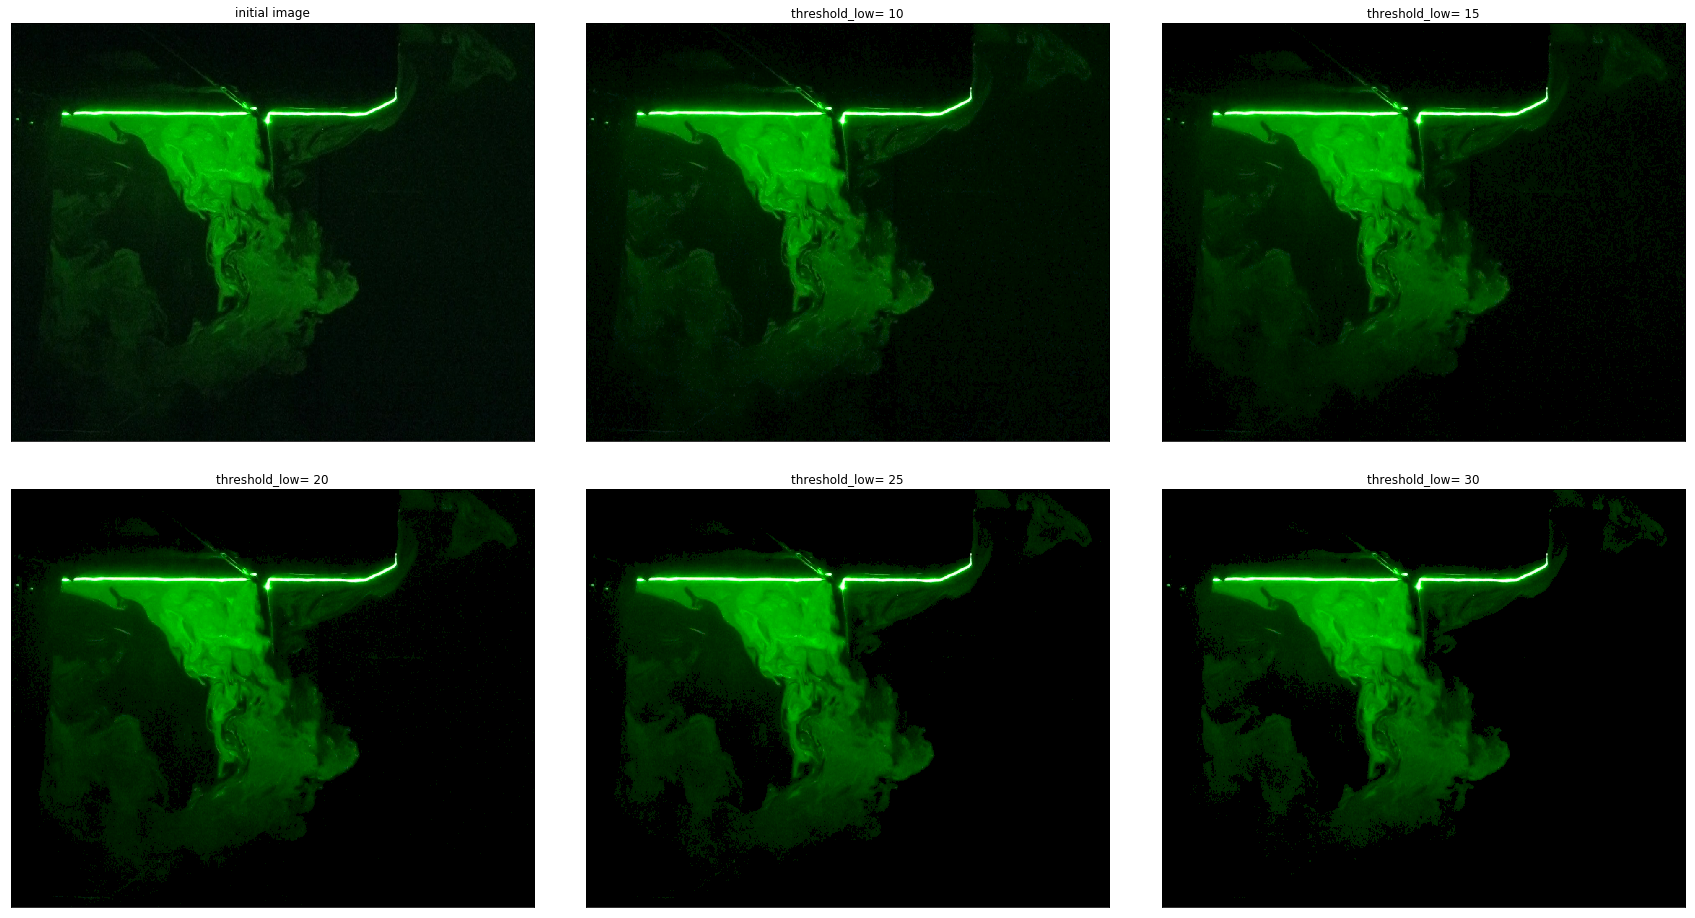

In [37]:
plt.figure(figsize=(30,30))
plt.subplot(231); plt.xticks([]); plt.yticks([]);
plt.title('initial image')
plt.imshow(img)

plt.subplot(232); plt.xticks([]); plt.yticks([]);
plt.title('threshold_low= 10')
plt.imshow(b1)

plt.subplot(233); plt.xticks([]); plt.yticks([]);
plt.title('threshold_low= 15')
plt.imshow(b2)

plt.subplot(234); plt.xticks([]); plt.yticks([]);
plt.title('threshold_low= 20')
plt.imshow(b3)

plt.subplot(235); plt.xticks([]); plt.yticks([]);
plt.title('threshold_low= 25')
plt.imshow(b4)

plt.subplot(236); plt.xticks([]); plt.yticks([]);
plt.title('threshold_low= 30')
plt.imshow(b5)

plt.subplots_adjust(wspace =0.1, hspace =-0.6)

# 高斯、中值、均值濾波

二值法消除大部分造點後，透過高斯、中值、均值濾波模糊後後也能淡化躁點，雖然會犧牲一點細節。

從圖片比較可以得知:
    1. 並且可以明顯看出kernel=5比kernel=3效果更好，原因右上方的煙顯得比較清楚。我認為煙變得比較明顯可能是因為這種積分類型的濾波器會將周圍的強度值做分配權重上的累加，因此如果kernel較大，且範圍內強度值不為0的pixel較多，會使得濾波器的結果讓強度值增強。
    2. 三種濾波方法，將圖片放大看，中值濾波是比較好的，因為高斯、均值在某些不需要部分(沒有煙的地方)的強度值比中值濾波還要高。故之後濾波皆使用中值濾波。

In [38]:
#------------------------------高斯濾波(輸入array)(使用padding增邊)------------------------------
b3_gau3x3 = filter_class.gaussian_filter_padding(b3, Variance_mode=20, n=3)
b3_gau5x5 = filter_class.gaussian_filter_padding(b3, Variance_mode=20, n=5)
#------------------------------中值濾波(輸入array)--------------------------------------------
b3_med3x3 = filter_class.median_filter(b3, n = 3)
b3_med5x5 = filter_class.median_filter(b3, n = 5)
#------------------------------均值濾波(輸入array)--------------------------------------------
b3_ave3x3 = filter_class.average_filter(b3, n = 3)
b3_ave5x5 = filter_class.average_filter(b3, n = 5)

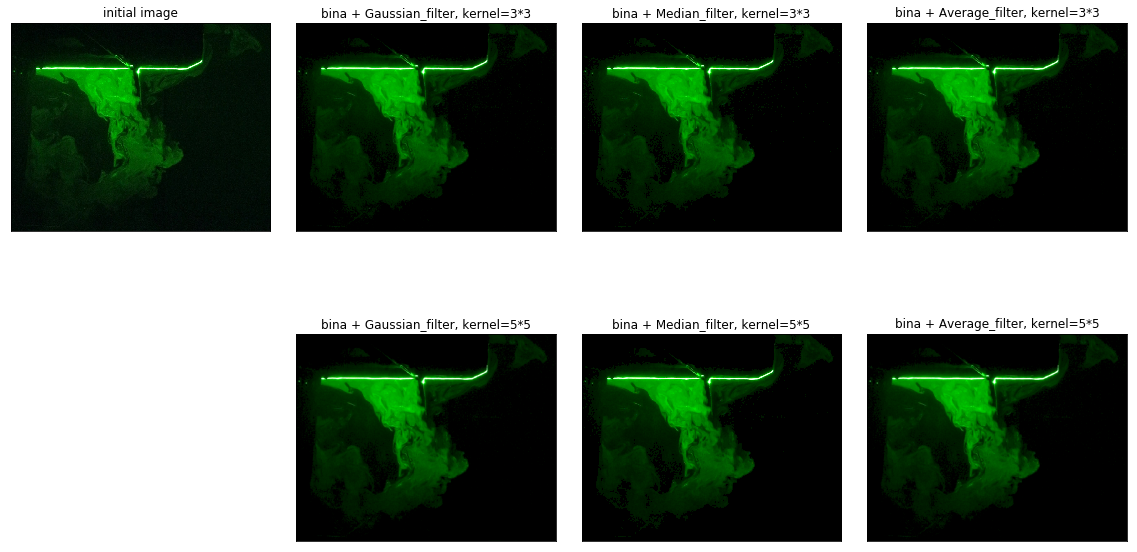

In [39]:
plt.figure(figsize=(20,20))
plt.subplot(241); plt.xticks([]); plt.yticks([]);
plt.title('initial image') ;plt.imshow(img)

plt.subplot(242); plt.xticks([]); plt.yticks([])
plt.title('bina + Gaussian_filter, kernel=3*3'); plt.imshow(b3_gau3x3)

plt.subplot(243); plt.xticks([]); plt.yticks([])
plt.title('bina + Median_filter, kernel=3*3'); plt.imshow(b3_med3x3)

plt.subplot(244); plt.xticks([]); plt.yticks([])
plt.title('bina + Average_filter, kernel=3*3'); plt.imshow(b3_ave3x3)

plt.subplot(246); plt.xticks([]); plt.yticks([])
plt.title('bina + Gaussian_filter, kernel=5*5'); plt.imshow(b3_gau5x5)

plt.subplot(247); plt.xticks([]); plt.yticks([])
plt.title('bina + Median_filter, kernel=5*5'); plt.imshow(b3_med5x5)

plt.subplot(248); plt.xticks([]); plt.yticks([])
plt.title('bina + Average_filter, kernel=5*5'); plt.imshow(b3_ave5x5)

plt.subplots_adjust(wspace =0.1, hspace =-0.6)

# 伽馬校正（Gamma correction）

從圖片可以發現，pixel強度值接近極值(亮&暗)的部分已經很清楚，但是對於強度中間值來說，卻顯得有點不明顯，因此為了強化這些中間值，可以使用Gamma correction達到目的。

以下先比較兩種色碼的Gamma correction，分別是:
    1. RGB，分別對RGB強度值做正規化，在進行Gamma correction。
    2. HSV，將RGB轉成HSV後，對V強度值(明度)做Gamma correction，再轉回RGB。
對以上兩種色碼觀察結果:
    1. 兩種色碼差別不大。(試過其他彩色圖片的結果是RGB顏色稍微失真)(在histogram equailzation，RGB彩色圖片只能將RGB轉HSV並對V做HE再轉回RGB。)
    2. 確實使右上、左下原本較不清楚的煙更加明顯。
    3. 但也使得部分躁點增強。

In [53]:
# 1.RGB
gamma_RGB = filter_class.gamma_correction_RGB(b3_med5x5, gamma = 0.9, c = 1)
# 2.HSV
gamma_HSV = other_class.RGB_to_HSV(b3_med5x5)
gamma_HSV = filter_class.gamma_correction_HSV(gamma_HSV, gamma = 0.9, c = 1)
gamma_HSV = other_class.HSV_to_RGB(gamma_HSV)

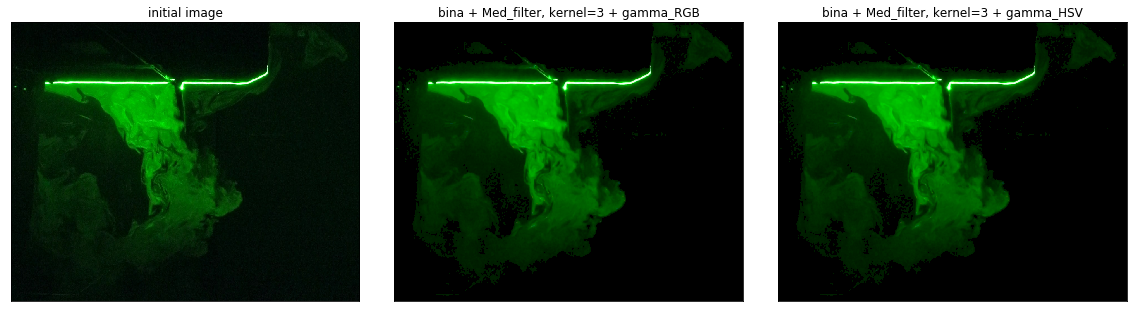

In [54]:
plt.figure(figsize=(20,20))
plt.subplot(131); plt.xticks([]); plt.yticks([]);
plt.title('initial image') ;plt.imshow(img)

plt.subplot(132); plt.xticks([]); plt.yticks([])
plt.title('bina + Med_filter, kernel=3 + gamma_RGB'); plt.imshow(gamma_RGB)

plt.subplot(133); plt.xticks([]); plt.yticks([])
plt.title('bina + Med_filter, kernel=3 + gamma_HSV'); plt.imshow(gamma_HSV)
plt.subplots_adjust(wspace =0.1, hspace =-0.6)

# 直方圖等化(histogram equalization)

很明顯，因為這方法並無法調整強度，因此過強的對比強度反而效果不好。
另外這個方法因為是對整體的對比度調整，另外也有局部的方式，因為還沒有寫這部分的，所以先跳過。

In [56]:
histo_eq = other_class.RGB_to_HSV(gamma_HSV)
histo_eq = filter_class.contrast_histogram_equalization_v(histo_eq)
histo_eq = other_class.HSV_to_RGB(histo_eq)

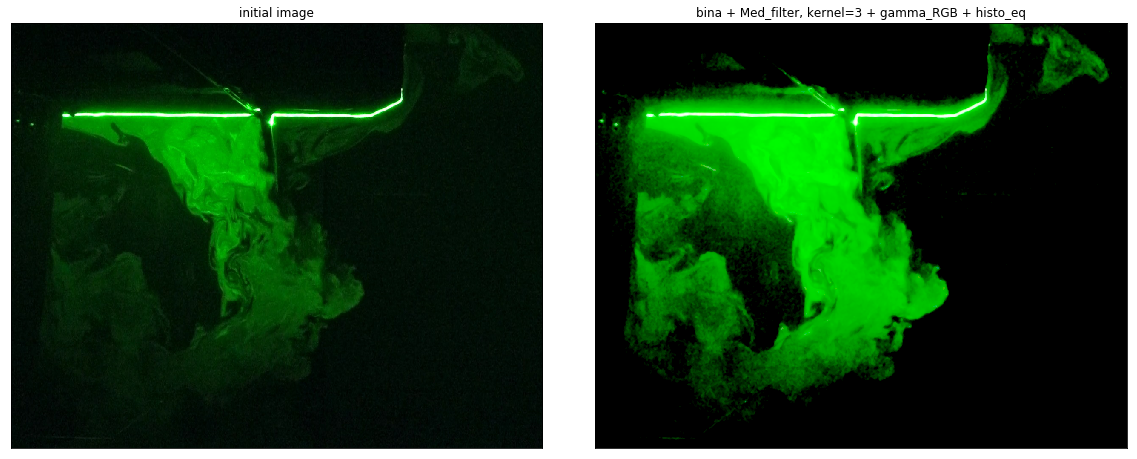

In [57]:
plt.figure(figsize=(20,20))
plt.subplot(121); plt.xticks([]); plt.yticks([]);
plt.title('initial image') ;plt.imshow(img)

plt.subplot(122); plt.xticks([]); plt.yticks([])
plt.title('bina + Med_filter, kernel=3 + gamma_RGB + histo_eq'); plt.imshow(histo_eq)
plt.subplots_adjust(wspace =0.1, hspace =-0.6)

# 銳化 (sharpening filter)

以下使用了兩種kernel，分別是3、5，比較一下結果:
    1. 以銳化效果角度而言，是kernel=5的細節銳化效果更好，kernel=3的細節較為模糊。
    2. 以局部而言，銳化確實起到了使細節更清楚得效果，但整體而言還是將噪點增強了。
    3. 解決辦法:除非把噪點清得很乾淨，不然銳化會使噪點增強。或是使用對比將強度值偏弱的噪點強度值降低。

In [62]:
sharpen3x3 = filter_class.Sharpening_filter_laplacian_3x3(gamma_HSV)
sharpen5x5 = filter_class.Sharpening_filter_laplacian_5x5(gamma_HSV)

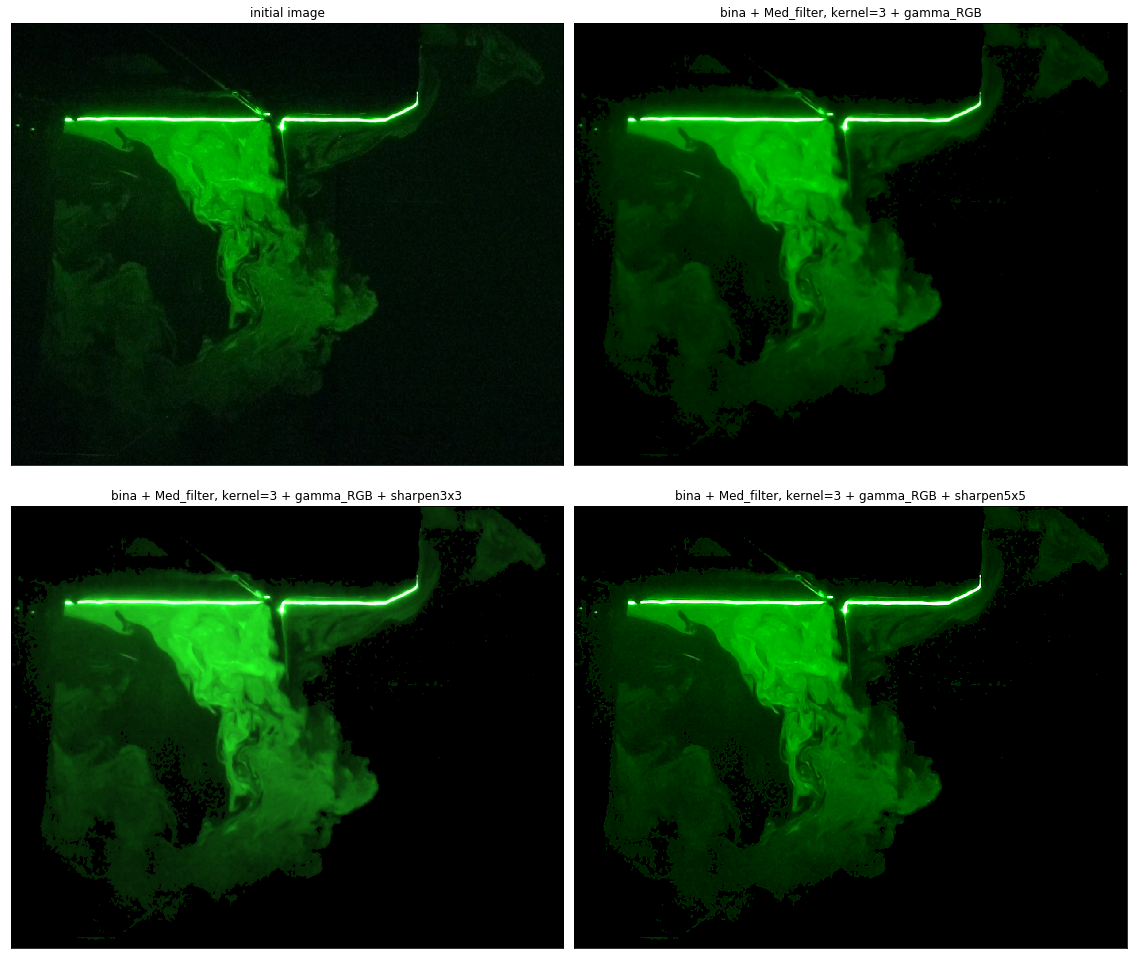

In [76]:
plt.figure(figsize=(20,20))
plt.subplot(221); plt.xticks([]); plt.yticks([]);
plt.title('initial image') ;plt.imshow(img)

plt.subplot(222); plt.xticks([]); plt.yticks([]);
plt.title('bina + Med_filter, kernel=3 + gamma_RGB') ;plt.imshow(gamma_HSV)

plt.subplot(223); plt.xticks([]); plt.yticks([]);
plt.title('bina + Med_filter, kernel=3 + gamma_RGB + sharpen3x3') ;plt.imshow(sharpen3x3)

plt.subplot(224); plt.xticks([]); plt.yticks([])
plt.title('bina + Med_filter, kernel=3 + gamma_RGB + sharpen5x5'); plt.imshow(sharpen5x5)
plt.subplots_adjust(wspace =0.02, hspace =-0.2)

# 結論

從上面的四張圖可以看到，左上原圖經過處理過後，明顯的使得部分的煙更加清楚，也除去部分背景雜訊。

# 功能查詢:

In [ ]:
def Main():
    # 匯入圖片，並轉成 array
    image_path = 'source/gaussian-noise.jpg'
    init_image = other_class.open_image(image_path)
    output_image = np.array(init_image) # array
    #------------------------------高斯濾波(輸入array)(使用padding增邊)------------------------------
    output_image = filter_class.gaussian_filter_padding(image_array, Variance_mode ='gaussian',n=3)
    
    
    #------------------------------高斯濾波(輸入為透過other_class.to_mesh(output_image, large_mesh_size)先切成數分的windows)------------------------------
    # 把圖片切成大 mesh
    large_mesh_size = 11
    n = 2   #kernel
    output_image = other_class.to_mesh(output_image, large_mesh_size)
    
    '''
    Variance = 5 (默認為gaussian，通常直接給定Variance越大效果越好)
    n : kernel=2*2
    卷積方式 : 沒有padding，根據slider window的大小位置決定其他pixel的座標。
    '''
    output_image = filter_class.gaussian_filter(output_image, init_image, 5, n=3)
    
    # mesh轉成array
    output_image = other_class.mesh_to_array(output_image, init_image, large_mesh_size)
    
    #------------------------------中值濾波(輸入array)-----------------------------
    n : kernel(默認為3)
    卷積方式 : 在圖片周圍根據kernel增加padding
    output_image = filter_class.median_filter(output_image, n = 3)
    
    #------------------------------均值濾波(輸入array)-----------------------------
    n : kernel(默認為3)
    卷積方式 : 在圖片周圍根據kernel增加padding
    output_image = filter_class.average_filter(output_image, n = 3)

    #------------------------------二值化(輸入array)-------------------------------
    threshold_low  : 強度低於以下為0
    threshold_high : 強度高於以下為255
    output_image = filter_class.binarization(output_image, threshold_low=30, threshold_high=225 )
    
    #------------------------------銳化濾波(輸入array)-----------------------------
    卷積方式 : 在圖片周圍根據kernel增加padding
    output_image = filter_class.Sharpening_filter_laplacian_3x3(output_image,c=50)
    output_image = filter_class.Sharpening_filter_laplacian_5x5(output_image)
    
    #------------------------------對比(histogram equalization)-------------------
    #只能用在rgb相等的圖片
    output_image = filter_class.contrast_histogram_equalization_rgb(output_image)
    #先將RGB轉HSV，再對V值做histgram euualization，再轉回RGB
    #缺點 : 1.無法精準控制增強的強度，如果以我的論文圖片來說，強度值低與高落差很大(不是很案就是很亮)，
    output_image = other_class.RGB_to_HSV(output_image)
    output_image = filter_class.contrast_histogram_equalization_v(output_image)
    output_image = other_class.HSV_to_RGB(output_image)
    
    #------------------------------gamma--------------------------
    output_image = filter_class.gamma_correction_HSV(image_array, gamma = 0.67, c = 1)
    output_image = filter_class.gamma_correction_RGB(image_array, gamma = 0.67, c = 1)
    # 並將array轉成圖片，並儲存
    show_image = Image.fromarray(output_image, 'RGB')
    show_image.save('result/new_cat.jpg')